# COLLABORATIV FILTERING (implicit)

Exploration du module implicit permetant la gestion des données implicites

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix

from sklearn.metrics import roc_auc_score

import itertools

from tqdm import tqdm

## Data import

In [2]:
df_train = pd.read_csv('filtered data/filtered_rating_fm_dataset_train.csv', index_col=0)

In [3]:
df_test = pd.read_csv('filtered data/filtered_rating_fm_dataset_test.csv', index_col=0)

## Data preparation

In [4]:
df_gb = df_train.groupby(['user_id','track_id']).mean().reset_index()

In [5]:
item = np.array(df_gb[['track_id']].values).T[0]
user = np.array(df_gb[['user_id']].values).T[0]
weight = np.array(df_gb[['rating']].values).T[0]

In [6]:
mat_music = coo_matrix((weight,(item, user)))
mat_music.shape

(80600, 1001)

## Class métrique K_best

In [7]:
class k_best():
    def __init__(self, user_tracks, recomended_tracks):
        self.user_tracks = user_tracks
        self.recomended_tracks = recomended_tracks
    
    def CG(self):
        
        return len(set(self.recomended_tracks).intersection(set(self.user_tracks)))
    
    def DCG(self):
        
        result = 0
        for i,id in enumerate(self.recomended_tracks):
            
            if id in self.user_tracks:
                result+=1/np.log2(i+2)

        return result
    
    def IDCG(self):
        
        a = self.CG()
        result=0
        
        for i in range (a):
            result+=1/np.log2(i+2)
        
        return result
    
    def NDCG(self):
        if self.IDCG()!=0:
            result = self.DCG()/self.IDCG()
        else:
            result=0
            
        return result
    
    def P_at_k(self):
        
        return self.CG()/len(self.recomended_tracks)

    
    def __str__(self):
        
        result = 'K_best ressults: \n'
        result+= f'CG = {self.CG()}\n'
        result+= f'DCG = {self.DCG()}\n'
        result+= f'NDCG = {self.NDCG()}\n'
        result+= f'P@K = {self.P_at_k()}\n'
        
        return result

## Premier Modèle

In [8]:
import implicit

# Initialisation du modèle
model_music = implicit.als.AlternatingLeastSquares(factors=100,
                                                   use_native=True, 
                                                   use_cg=True, 
                                                   calculate_training_loss=True, 
                                                   num_threads=1, 
                                                   iterations=30)

# Entrainemt du model item/user/confidence weights
model_music.fit(mat_music.T)

F:\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
F:\anaconda3\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006001472473144531 seconds
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

In [9]:
import implicit
print(implicit.__version__)
print(implicit.__name__)

0.6.1
implicit


### Test sur un utilisateur

In [36]:
user = 5

user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])

recomended_tracks = set([x[0] for x in model_music.recommend(user, mat_music.tocsr()[user+1], 50)])
#recomended_tracks_filtered = set([x[0] for x in model_music.recommend(user, mat_music[user].T.tocsr(), 50, filter_items=user_tracks_train)])

In [37]:
mat_music.T.tocsr()[user].T.shape

(80600, 1)

In [38]:
print('train: ',len(user_tracks_train))
print('test: ',len(user_tracks_test))

train:  495
test:  238


### K_best

In [39]:
# Calcule des metriques sur train
k = k_best(user_tracks_train, recomended_tracks)
print(k)

K_best ressults: 
CG = 1
DCG = 0.6309297535714575
NDCG = 0.6309297535714575
P@K = 0.5



In [40]:
# Calcule des metriques sur test
k = k_best(user_tracks_test, recomended_tracks)
print(k)

K_best ressults: 
CG = 0
DCG = 0
NDCG = 0
P@K = 0.0



In [27]:
# Calcule des metriques sur test (recomendation filtrées des item déjà écoutés)
k = k_best(user_tracks_test, recomended_tracks_filtered)
print(k)

K_best ressults: 
CG = 12
DCG = 2.7562086632238274
NDCG = 0.5412034437427492
P@K = 0.24



### AUC_ROC

In [29]:
full_ranking=model_music.rank_items(user,mat_music.tocsr().T,list(set(item)))

id = [x[0] for x in full_ranking]
score = [x[1] for x in full_ranking]

df_temp = pd.DataFrame({'id': id, 'score': score})

In [38]:
df_temp['train'] = df_temp['id'].apply(lambda x: 1 if x in user_tracks_train else 0)
df_temp['test'] = df_temp['id'].apply(lambda x: 1 if x in user_tracks_test else 0)

In [39]:
y_pred = [1 if x>0 else 0 for x in df_temp['score']]

In [43]:
roc_train = roc_auc_score(df_temp['train'],y_pred)
roc_test = roc_auc_score(df_temp['test'],y_pred)

print('Train_AUC_ROC = ', roc_train)
print('Test_AUC_ROC = ', roc_test)

Train_ROC =  0.7216952848207034
Test_ROC =  0.657645635667834


## Grid serch (optimisation des paramètres)

In [45]:
factors = [20,30,40,50]
iterations = [10,30,40,50]

iter = itertools.product(factors,iterations)

In [47]:
result = list()

for fac,it in iter:
    
    print(f'model with n_facror={fac}, n_iteration={it}')

    model_music = implicit.als.AlternatingLeastSquares(factors=fac,
                                                 use_native=True, 
                                                 use_cg=True, 
                                                 calculate_training_loss=True, 
                                                 num_threads=1, 
                                                 iterations=it)

    model_music.fit(mat_music)
    
    train_scores = list()
    test_scores = list()
    user_id = list()

    for user in df_train['user_id'].unique():
        user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
        user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
        recomended_tracks = set([x[0] for x in model_music.recommend(user, mat_music.tocsr().T, 50)])

        k = k_best(user_tracks_train, recomended_tracks)
        train_scores.append(k.NDCG())

        if len(user_tracks_test)!=0:
            k = k_best(user_tracks_test, recomended_tracks)
            test_scores.append(k.NDCG())
        else:
            test_scores.append(0)
    
    
    result.append([f'model with n_facror={fac}, n_iteration={it}',
                  np.array(train_scores).mean(),
                  np.array(test_scores).mean()])
    
    
    print(f'train = {np.array(train_scores).mean()}')
    print(f'test = {np.array(test_scores).mean()}')
    print('###############################################################################\n\n')

model with n_facror=20, n_iteration=30


  0%|          | 0/30 [00:00<?, ?it/s]

train = 0.7518156497817303
test = 0.47131494601095303
###############################################################################


model with n_facror=20, n_iteration=40


  0%|          | 0/40 [00:00<?, ?it/s]

train = 0.7507808984088699
test = 0.4677122299164186
###############################################################################


model with n_facror=20, n_iteration=50


  0%|          | 0/50 [00:00<?, ?it/s]

train = 0.7487801690360968
test = 0.472487289088797
###############################################################################


model with n_facror=30, n_iteration=10


  0%|          | 0/10 [00:00<?, ?it/s]

train = 0.7868759737008172
test = 0.4689005813779506
###############################################################################


model with n_facror=30, n_iteration=30


  0%|          | 0/30 [00:00<?, ?it/s]

train = 0.7858838601631221
test = 0.4733195624485075
###############################################################################


model with n_facror=30, n_iteration=40


  0%|          | 0/40 [00:00<?, ?it/s]

train = 0.7851940893509768
test = 0.4701335909269173
###############################################################################


model with n_facror=30, n_iteration=50


  0%|          | 0/50 [00:00<?, ?it/s]

train = 0.7858348811803609
test = 0.47103264518429167
###############################################################################


model with n_facror=40, n_iteration=10


  0%|          | 0/10 [00:00<?, ?it/s]

train = 0.8142820059458624
test = 0.4661127739369801
###############################################################################


model with n_facror=40, n_iteration=30


  0%|          | 0/30 [00:00<?, ?it/s]

train = 0.8152503403215032
test = 0.47611190605141
###############################################################################


model with n_facror=40, n_iteration=40


  0%|          | 0/40 [00:00<?, ?it/s]

train = 0.8118912969094572
test = 0.47113163512574835
###############################################################################


model with n_facror=40, n_iteration=50


  0%|          | 0/50 [00:00<?, ?it/s]

train = 0.8137061131267838
test = 0.4705080955050482
###############################################################################


model with n_facror=50, n_iteration=10


  0%|          | 0/10 [00:00<?, ?it/s]

train = 0.8384186488339679
test = 0.4585721762181163
###############################################################################


model with n_facror=50, n_iteration=30


  0%|          | 0/30 [00:00<?, ?it/s]

train = 0.8346186916111844
test = 0.46570431802381645
###############################################################################


model with n_facror=50, n_iteration=40


  0%|          | 0/40 [00:00<?, ?it/s]

train = 0.8361396594760138
test = 0.46397797966303955
###############################################################################


model with n_facror=50, n_iteration=50


  0%|          | 0/50 [00:00<?, ?it/s]

train = 0.8353658654280485
test = 0.4576279921724669
###############################################################################




In [49]:
sorted(result, key = lambda x: x[2], reverse=True)[0]

['model with n_facror=40, n_iteration=30',
 0.8152503403215032,
 0.47611190605141]

## Entrainement du meilleur modèle

In [50]:
import implicit

# Initialisation du modèle
model_music = implicit.als.AlternatingLeastSquares(factors=40,
                                                   use_native=True, 
                                                   use_cg=True, 
                                                   calculate_training_loss=True, 
                                                   num_threads=1, 
                                                   iterations=30)

# Entrainemt du model item/user/confidence weights
model_music.fit(mat_music)

  0%|          | 0/30 [00:00<?, ?it/s]

## Evaluation sur tous les utilisateurs 

### K_best

In [51]:
train_scores = list()
test_scores = list()
test_scores_filtered = list()
user_id = list()

for user in tqdm(df_train['user_id'].unique()):
    user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
    user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
    recomended_tracks = set([x[0] for x in model_music.recommend(user, mat_music.tocsr().T, 50)])
    recomended_tracks_filtered = set([x[0] for x in model_music.recommend(user, mat_music.tocsr().T, 50, filter_items=user_tracks_train)])
    
    k = k_best(user_tracks_train, recomended_tracks)
    train_scores.append(k.NDCG())
    
    if len(user_tracks_test)!=0:
        k = k_best(user_tracks_test, recomended_tracks)
        test_scores.append(k.NDCG())
        
        k = k_best(user_tracks_test, recomended_tracks_filtered)
        test_scores_filtered.append(k.NDCG())
        
    else:
        test_scores.append(0)
    
    user_id.append(user)
    

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [01:32<00:00, 10.33it/s]


In [52]:
# best n_fact=40, it=30
print('Train_mean_NDCG = ', np.array(train_scores).mean())
print('Test_mean_NDCG = ', np.array(test_scores).mean())
print('Test_filtered_mean_NDCG = ', np.array(test_scores_filtered).mean())

Train_mean_NDCG =  0.8151113252189947
Test_mean_NDCG =  0.47042436405232707
Test_filtered_mean_NDCG =  0.6366227831237973


### AUC_ROC

In [53]:
def auc_score(df_train, df_test, model, mat, seuils=[0]):
    
    ids = df_train['user_id'].unique()
    
    recomendations = dict()
    
    auc_train_all=dict()
    auc_test_all=dict()
    
    for user in tqdm(ids):
        a=model.rank_items(user,mat.tocsr().T,list(set(item)))
        
        id = [x[0] for x in a]
        score = [x[1] for x in a]
        
        df_temp = pd.DataFrame({'id': id, 'score': score})
        
        user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
        user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
        
        df_temp['train'] = df_temp['id'].apply(lambda x: 1 if x in user_tracks_train else 0)
        df_temp['test'] = df_temp['id'].apply(lambda x: 1 if x in user_tracks_test else 0)
        
        
        y_true_test = df_temp['test']
        y_true_train = df_temp['train']
        
        
        for s in seuils:
            
            try:


                y_pred = [1 if x>s else 0 for x in df_temp['score']]

                auc_test = roc_auc_score(y_true_test, y_pred)
                auc_train = roc_auc_score(y_true_train, y_pred)
                
                try:
                    auc_train_all[s].append(auc_train)
                    auc_test_all[s].append(auc_test)
                except:
                    auc_train_all[s] = [auc_train]
                    auc_test_all[s] = [auc_test]
                
            except:
                pass
        

    return auc_train_all, auc_test_all

### Seuil de 0

In [55]:
auc_train_all_zero, auc_test_all_zero = auc_score(df_train, df_test, model_music, mat_music)

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [06:36<00:00,  2.42it/s]


In [56]:
roc_train = np.array([x for x in auc_train_all_zero[0]]).mean()
roc_test = np.array([x for x in auc_test_all_zero[0]]).mean()

print('Train_AUC_ROC = ', roc_train)
print('Test_AUC_ROC = ', roc_test)

Train_ROC =  0.6870953055322718
Test_ROC =  0.6639864849287203


### Recherche du meilleur seuil

In [58]:
auc_train_all, auc_test_all = auc_score(df_train, df_test, model_music, mat_music, np.linspace(-0.25,1,26))

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [22:55<00:00,  1.43s/it]


Text(0.5, 0, 'Seuil')

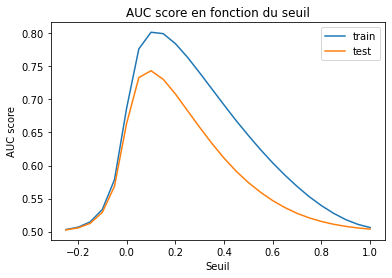

In [59]:
x=list()
y_a=list()
y_b=list()
    
for key in auc_train_all.keys():
    score_train = np.array([x for x in auc_train_all[key]]).mean()
    score_test = np.array([x for x in auc_test_all[key]]).mean()
    
    x.append(key)
    y_a.append(score_train)
    y_b.append(score_test)


plt.plot(x,y_a, label='train')
plt.plot(x,y_b, label='test')
plt.legend()
plt.title('AUC score en fonction du seuil')
plt.ylabel('AUC score')
plt.xlabel('Seuil')

plt.savefig("ROC score en fonction du seuil, implicit", dpi=300, pad_inches=0.1,bbox_inches='tight')

In [67]:
i = np.array(y_b).argmax()

print('Train_best_AUC_ROC = ', round(y_a[i],3))
print('Test_best_AUC_ROC = ', round(y_b[i],3))
print('Seuil_best = ', round(x[i],3))


Train_best_AUC_ROC =  0.802
Test_best_AUC_ROC =  0.743
Seuil_best =  0.1
